
# Adding Limit Orders to the Trading Bot (Take Profit & Stop Loss) 

In [1]:
import sys
sys.path.append("../")
import pandas as pd
import numpy as np
import tpqoa
from datetime import datetime, timedelta, timezone
import time
import pytz
from datetime import datetime

import matplotlib.pyplot as plt
from trading import MyTT

In [2]:
instrument = "EUR_USD"
bar_length = timedelta(minutes = 1)
SMA = 200
dev = 2

In [ ]:
# raw_data = None
# now = datetime.utcnow()
       
# now = now - timedelta(microseconds = now.microsecond)
# past = now - timedelta(days = 2)


# print (f"Getting candles for {instrument}, from {past} to {now}")

# raw_df = tpqoa.tpqoa("../../config/oanda_demo.cfg").get_history(instrument = instrument, start = past, end = now,
#                        granularity = "S30", price = "M", localize = True).c.dropna().to_frame()

# raw_df.rename(columns = {"c":instrument}, inplace = True)


# # last_bar = raw_data.index[-1].to_pydatetime().replace(tzinfo=None)
        




In [3]:
raw_df = pd.read_pickle(f"../../data/backtest_{instrument}.pcl")

In [ ]:
raw_df

In [ ]:
def do_math(df):
    
    df["SMA"] = df[instrument].rolling(SMA).mean()
    std = df[instrument].rolling(SMA).std() * dev

    df["Lower"] = df["SMA"] - std
    df["Upper"] = df["SMA"] + std

    df["RSI"] = df[instrument].rolling(29).apply(lambda x: MyTT.RSI(x.values, N=28))
    df["rsi_prev"] = df["RSI"].shift(1)
    df["rsi_max"] = df ['RSI'].rolling(8).max()
    df["rsi_min"] = df ['RSI'].rolling(8).min()

    df["price_max"] = df [instrument].rolling(8).max()
    df["price_min"] = df [instrument].rolling(8).min()

    df["momentum"] = df[instrument].rolling(8).apply(lambda x: (x.iloc[0] - x.iloc[-1])/ x.iloc[0])        
    df["momentum_prev"] = df["momentum"].shift(1)

    df.dropna(subset=["RSI", "SMA"], inplace = True)

    return df

In [ ]:
raw_df = do_math(raw_df)

In [ ]:
raw_df

In [4]:
raw_df.tail(20)

,ask,bid,EUR_USD
time,,,
2024-02-16 21:49:30,1.07770,1.07756,1.077630
2024-02-16 21:50:00,1.07770,1.07756,1.077630
2024-02-16 21:50:30,1.07765,1.07750,1.077575
2024-02-16 21:51:00,1.07769,1.07752,1.077605
2024-02-16 21:51:30,1.07774,1.07758,1.077660
2024-02-16 21:52:00,1.07772,1.07756,1.077640
2024-02-16 21:52:30,1.07774,1.07757,1.077655
2024-02-16 21:53:00,1.07769,1.07753,1.077610
2024-02-16 21:53:30,1.07770,1.07754,1.077620


In [13]:
filtered_df = raw_df.query("time >= '2024-01-01 00:00:00' and time < '2024-01-05 23:59:59'")

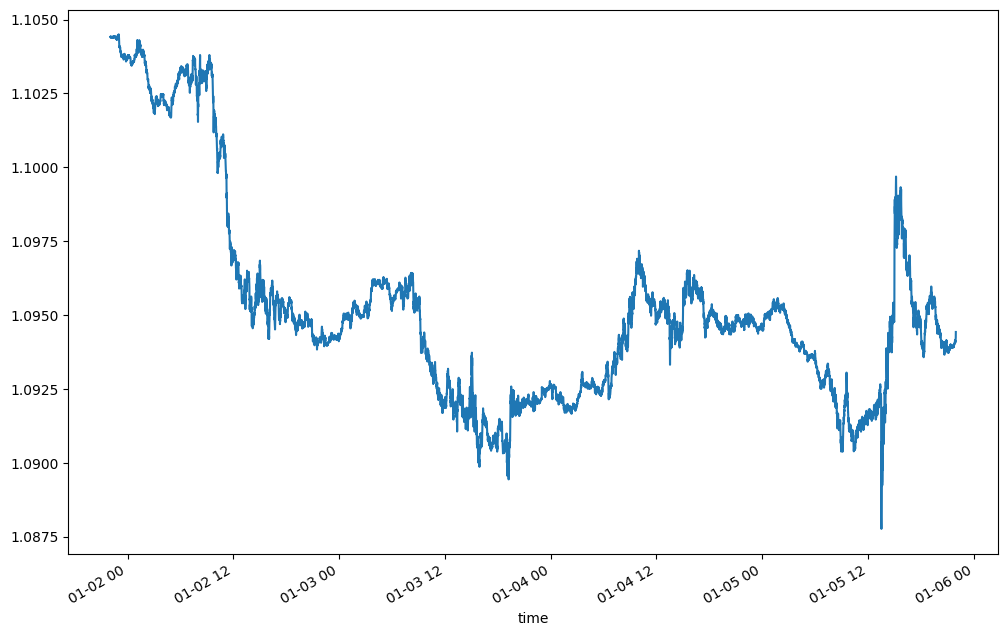

In [14]:
filtered_df[instrument].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

In [19]:
filtered_df = raw_df.query("time >= '2024-01-08 00:00:00' and time < '2024-01-08 23:59:59'")

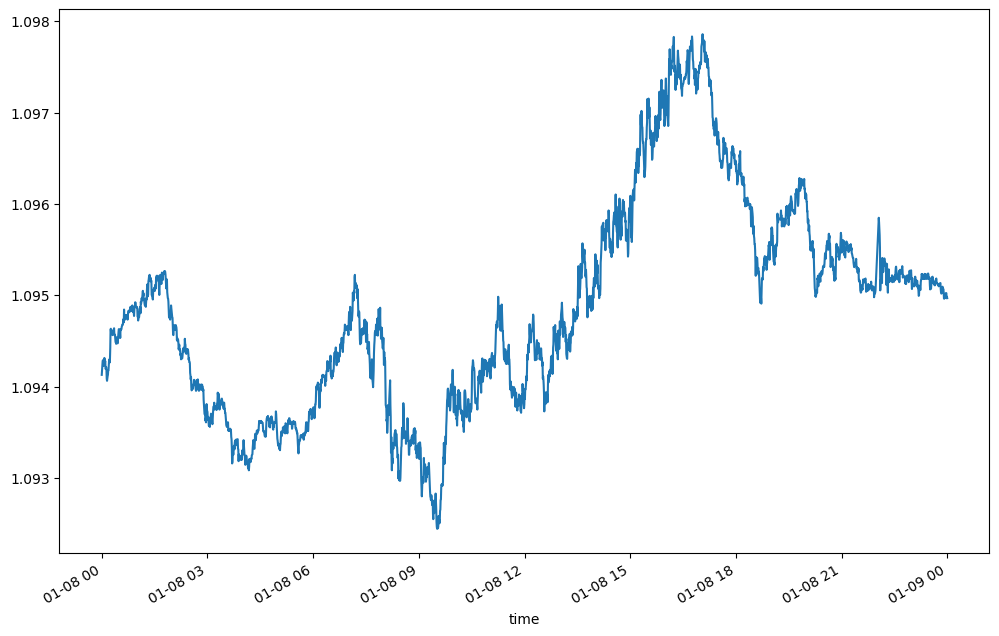

In [20]:
filtered_df[instrument].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

In [ ]:
trader = ConTrader("oanda.cfg", "EUR_USD", "1min", window = 1, units = 10000)

In [ ]:
trader.start_trading(days = 5, max_attempts =  3, wait = 20, wait_increase = 0) # trade 200 ticks

In [ ]:
trader.data

In [ ]:
trader.position

## Oanda: How to create Stop Loss and Take Profit Orders

In [ ]:
trader

In [ ]:
current_price = trader.data[trader.instrument].iloc[-1]
current_price

__Stop Loss (distance)__

Distance of 0.01 means 100 pips -> works in both directions (Long and Short)

If Current EUR/USD FX rate is 1.08:
- Stop Loss Price for LONG position: 1.08 - 0.01 = 1.07
- Stop Loss Price for SHORT position: 1.08 + 0.01 = 1.09

In [ ]:
# open long position with sl
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            sl_distance = 0.01)
order

In [ ]:
# closing trade -> limit order automatically cancelled
order = trader.create_order(trader.instrument, -trader.units, suppress = True, ret = True)
order

__Take Profit (price)__

If Current EUR/USD FX rate is 1.08:
- Take Profit Price for LONG position must be greater -> 1.09
- Take Profit Price for SHORT position must be less -> 1.07 

In [ ]:
# open long position with tp
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            tp_price = 1.09) # adjust tp_price based on current price!
order

In [ ]:
# close long position
order = trader.create_order(trader.instrument, -trader.units, suppress = True, ret = True)
order

__Stop Loss and Take Profit__

SL and TP can be combined!

In [ ]:
# open long position with sl & tp
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            sl_distance = 0.01, tp_price = 1.09) # adjust tp_price based on current price!
order

In [ ]:
# close long position
order = trader.create_order(trader.instrument, -trader.units, suppress = True, ret = True)
order

__Trailing Stop Loss__

Remember: Trailing Stop Loss Price moves if price moves into the right direction (Long position: increase, Short position: decrease)

In [ ]:
# open long position with tsl
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            tsl_distance = 0.01)
order

In [ ]:
# close long position
order = trader.create_order(trader.instrument, -trader.units, suppress = True, ret = True)
order

## Oanda: Stop Loss and Take Profit Orders - Pitfalls

In [ ]:
trader

In [ ]:
# if sl_distance is 1 pip or less -> order Cancelled.
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            sl_distance = 0.0001)
order

In [ ]:
order["price"] # consequence in the Trader Bot (KeyError: "price")

In [ ]:
# if sl_distance has too many (>5) decimals -> order Cancelled.
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            sl_distance = 0.014509485)
order

In [ ]:
# if tp_price has too many (> 2-5) decimals -> order Cancelled.
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            tp_price = 1.094585684)
order

In [ ]:
# if tp_price is less (LONG) or greater (SHORT) than current price -> order Cancelled.
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            tp_price = 1.06)
order

## Oanda: Setting SL Distances and TP Prices in real-time

__Setting SL/TSL Distance__

In [ ]:
trader

In [ ]:
current_price = trader.get_prices(trader.instrument)[2]
current_price

Typically: Define Maximum Loss in % (e.g. 1% loss -> 10% if leverage == 10)

In [ ]:
sl_perc = 0.01 # SL Event if Price moves in the wrong direction by 1%

In [ ]:
sl_dist = round(current_price * sl_perc, 4) # don´t forget rounding!!!
sl_dist

In [ ]:
# sl_price_long
current_price - sl_dist

In [ ]:
# sl_price_short
current_price + sl_dist

__Setting TP Price__

In [ ]:
target_position = 1 # Going Long

In [ ]:
tp_perc = 0.01 # if Price moves by 1% in the right direction

In [ ]:
if target_position == 1:
    tp_price = round(current_price * (1 + tp_perc), 2) 
elif target_position == -1:
    tp_price = round(current_price * (1 - tp_perc), 2)     

In [ ]:
tp_price

In [ ]:
# open long position with sl & tp
order = trader.create_order(trader.instrument, trader.units, suppress = True, ret = True,
                            sl_distance = sl_dist, tp_price = tp_price) # adjust tp_price based on current price!
order

In [ ]:
# close long position
order = trader.create_order(trader.instrument, -trader.units, suppress = True, ret = True)
order

## Oanda: Check for SL/TP Events

__Problem in Trading Bot: it doesn´t record TP/SL trades__

In [ ]:
trader.position = 1
trader.position # trading position recorded by the class (-1, 0, 1)

In [ ]:
exp_position = round(trader.position*trader.units, 0) # expected_position in EUR units
exp_position

In [ ]:
positions = trader.get_positions() # open positions on Oanda.com
positions

In [ ]:
# actual/true EUR/USD position in EUR units
actual_position = 0
for pos in positions:
    if pos["instrument"] == trader.instrument:
        actual_position = round(float(pos["long"]["units"]) + float(pos["short"]["units"]), 0)
actual_position

__Double-Check if expected EUR/USD position != actual/true EUR/USD position__

(strong indication for SL/TP Event)

In [ ]:
if actual_position != exp_position: # if not equal
    trader.position = actual_position / trader.units # set true/actual trading position
    print("Go Neutral and Stop Trading Session") # most reasonable action to be taken

In [ ]:
trader.position

## Oanda: Adding Stop Loss & Take Profit

In [ ]:
import pandas as pd
import numpy as np
import tpqoa
from datetime import datetime, timedelta
import time

In [ ]:
class ConTrader(tpqoa.tpqoa):
    def __init__(self, conf_file, instrument, bar_length, window, units, sl_perc = None, tsl_perc = None, tp_perc = None):
        super().__init__(conf_file)
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length)
        self.tick_data = pd.DataFrame()
        self.raw_data = None
        self.data = None 
        self.last_bar = None
        self.units = units
        self.position = 0
        self.profits = [] 
        self.sl_perc = sl_perc # NEW
        self.tsl_perc = tsl_perc # NEW
        self.tp_perc = tp_perc # NEW
        
        #*****************add strategy-specific attributes here******************
        self.window = window
        #************************************************************************
    
    def get_most_recent(self, days = 5):
        while True:
            time.sleep(2)
            now = datetime.utcnow()
            now = now - timedelta(microseconds = now.microsecond)
            past = now - timedelta(days = days)
            df = self.get_history(instrument = self.instrument, start = past, end = now,
                                   granularity = "S5", price = "M", localize = False).c.dropna().to_frame()
            df.rename(columns = {"c":self.instrument}, inplace = True)
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()).tz_localize("UTC") - self.last_bar < self.bar_length:
                break
            
    def start_trading(self, days, max_attempts = 5, wait = 20, wait_increase = 0): # Error Handling
        attempt = 0
        success = False
        while True:
            try:
                self.get_most_recent(days)
                self.stream_data(self.instrument)
            except Exception as e:
                print(e, end = " | ")
            else:
                success = True
                break    
            finally:
                attempt +=1
                print("Attempt: {}".format(attempt), end = '\n')
                if success == False:
                    if attempt >= max_attempts:
                        print("max_attempts reached!")
                        try: # try to terminate session
                            time.sleep(wait)
                            self.terminate_session(cause = "Unexpected Session Stop (too many errors).")
                        except Exception as e:
                            print(e, end = " | ")
                            print("Could not terminate session properly!")
                        finally: 
                            break
                    else: # try again
                        time.sleep(wait)
                        wait += wait_increase
                        self.tick_data = pd.DataFrame()
        
    def on_success(self, time, bid, ask):
        print(self.ticks, end = '\r', flush = True)
        
        recent_tick = pd.to_datetime(time)
        
        # define stop
        if self.ticks >= 200:
            self.terminate_session(cause = "Scheduled Session End.")
            return
        
        # collect and store tick data
        df = pd.DataFrame({self.instrument:(ask + bid)/2}, 
                          index = [recent_tick])
        self.tick_data = pd.concat([self.tick_data, df]) 
        
        # if a time longer than the bar_lenght has elapsed between last full bar and the most recent tick
        if recent_tick - self.last_bar >= self.bar_length:
            self.resample_and_join()
            self.define_strategy()
            #self.execute_trades() now called inside self.check_positions()
            self.check_positions()
            
    def resample_and_join(self):
        self.raw_data = pd.concat([self.raw_data, self.tick_data.resample(self.bar_length, 
                                                                          label="right").last().ffill().iloc[:-1]])
        self.tick_data = self.tick_data.iloc[-1:]
        self.last_bar = self.raw_data.index[-1]
        
    def define_strategy(self): # "strategy-specific"
        df = self.raw_data.copy()
        
        #******************** define your strategy here ************************
        df["returns"] = np.log(df[self.instrument] / df[self.instrument].shift())
        df["position"] = -np.sign(df.returns.rolling(self.window).mean())
        #***********************************************************************
        
        self.data = df.copy()
        
    def execute_trades(self):
        
        # NEW - determne SL distance and TP Price
        current_price = self.data[self.instrument].iloc[-1]
        
        if self.sl_perc:
            sl_dist = round(current_price * self.sl_perc, 4) 
        else: 
            sl_dist = None
            
            
        if self.tsl_perc:
            tsl_dist = round(current_price * self.tsl_perc, 4) 
        else: 
            tsl_dist = None
            
        
        if self.tp_perc:
            if self.data["position"].iloc[-1] == 1:
                tp_price = round(current_price * (1 + self.tp_perc), 2) 
            elif self.data["position"].iloc[-1] == -1:
                tp_price = round(current_price * (1 - self.tp_perc), 2)      
        else: 
            tp_price = None
        
        if self.data["position"].iloc[-1] == 1:
            if self.position == 0:
                order = self.create_order(self.instrument, self.units, suppress = True, ret = True,
                                          sl_distance = sl_dist, tsl_distance = tsl_dist, tp_price = tp_price)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = self.create_order(self.instrument, self.units * 2, suppress = True, ret = True,
                                          sl_distance = sl_dist, tsl_distance = tsl_dist, tp_price = tp_price) 
                self.report_trade(order, "GOING LONG")  
            self.position = 1
        elif self.data["position"].iloc[-1] == -1: 
            if self.position == 0:
                order = self.create_order(self.instrument, -self.units, suppress = True, ret = True,
                                          sl_distance = sl_dist, tsl_distance = tsl_dist, tp_price = tp_price)
                self.report_trade(order, "GOING SHORT")  
            elif self.position == 1:
                order = self.create_order(self.instrument, -self.units * 2, suppress = True, ret = True,
                                          sl_distance = sl_dist, tsl_distance = tsl_dist, tp_price = tp_price)
                self.report_trade(order, "GOING SHORT")  
            self.position = -1
        elif self.data["position"].iloc[-1] == 0: 
            if self.position == -1:
                order = self.create_order(self.instrument, self.units, suppress = True, ret = True) 
                self.report_trade(order, "GOING NEUTRAL")  
            elif self.position == 1:
                order = self.create_order(self.instrument, -self.units, suppress = True, ret = True)
                self.report_trade(order, "GOING NEUTRAL")  
            self.position = 0
    
    def report_trade(self, order, going):  
        self.order_id = order["id"] # Added! Order_ID of the latest recorded trade
        time = order["time"]
        units = order["units"]
        price = order["price"]
        pl = float(order["pl"])
        self.profits.append(pl)
        cumpl = sum(self.profits)
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | P&L = {} | Cum P&L = {}".format(time, units, price, pl, cumpl))
        print(100 * "-" + "\n")  
        
    def terminate_session(self, cause):
        self.stop_stream = True
        if self.position != 0:
            close_order = self.create_order(self.instrument, units = -self.position * self.units,
                                            suppress = True, ret = True) 
            self.report_trade(close_order, "GOING NEUTRAL")
            self.position = 0
        print(cause, end = " | ")
    
    def check_positions(self): # NEW!
        exp_position = self.position*self.units # get current (exp.) position
        
        # get current actual position
        try:
            positions = self.get_positions()
            actual_position = 0
            for pos in positions:
                if pos["instrument"] == self.instrument:
                    actual_position = round(float(pos["long"]["units"]) + float(pos["short"]["units"]), 0)
        except:
            actual_position = exp_position 
        
        if actual_position != exp_position: # if mismatch (sl/tp triggered)
            self.position = actual_position / self.units # update self.position
            try:
                latest_actions = self.get_transactions(self.order_id) # get all actions since last recorded trade (excl.)
                for action in latest_actions:
                    if action["type"] == "ORDER_FILL": # last filled order/trade (sl/tp trade!) 
                        self.report_trade(action, "GOING NEUTRAL") # report sl/tp trade
            except:
                pass
            finally:
                self.terminate_session("SL/TP Event!") # stop session
        elif self.position != self.data["position"].iloc[-1]: # if no mismatch and trade required
            self.execute_trades()
        else: # if no mismatch and no trade required
            pass

In [ ]:
trader = ConTrader("oanda.cfg", "EUR_USD", "1min", window = 1, units = 10000,
                   sl_perc = 0.01, tp_perc = 0.01)

In [ ]:
trader.start_trading(days = 5, max_attempts =  3, wait = 20, wait_increase = 0)

## IBKR: Contrader Class without Take Profit & Stop Loss (Recap)

_Disclaimer: <br>
The following illustrative examples are for general information and educational purposes only. <br>
It is neither investment advice nor a recommendation to trade, invest or take whatsoever actions.<br>
The below code should only be used in combination with an IBKR Practice/Demo Account and NOT with a Live Trading Account._

In [ ]:
from ib_insync import * 
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import display, clear_output
util.startLoop()

In [ ]:
def start_session():
    global last_update, session_start
    
    last_update = dt.datetime.utcnow() 
    session_start = pd.to_datetime(last_update).tz_localize("utc")
    
    initialize_stream()  
    stop_session()

def initialize_stream(): 
    global bars, last_bar
    
    bars = ib.reqHistoricalData(
            contract,
            endDateTime='',
            durationStr='1 D',
            barSizeSetting=freq,
            whatToShow='MIDPOINT',
            useRTH=True,
            formatDate=2,
            keepUpToDate=True)
    last_bar = bars[-1].date
    bars.updateEvent += onBarUpdate 
    
def onBarUpdate(bars, hasNewBar):  
    global df, last_bar, last_update
    
    last_update = dt.datetime.utcnow() 
    
    if bars[-1].date > last_bar: 
        last_bar = bars[-1].date
    
        # Data Processing
        df = pd.DataFrame(bars)[["date", "open", "high", "low", "close"]].iloc[:-1] 
        df.set_index("date", inplace = True)
        
        ####################### Trading Strategy ###########################
        df = df[["close"]].copy()
        df["returns"] = np.log(df["close"] / df["close"].shift())
        df["position"] = -np.sign(df.returns.rolling(window).mean())
        ####################################################################
        
        # Trading
        target = df["position"][-1] * units
        execute_trade(target = target)
        
        # Display
        clear_output(wait=True)
        display(df)
    else:
        try:
            trade_reporting()
        except:
            pass

def execute_trade(target):
    global current_pos
    
    # 1. get current Position
    try:
        current_pos = [pos.position for pos in ib.positions() if pos.contract.conId == conID][0]
    except:
        current_pos = 0
         
    # 2. identify required trades
    trades = target - current_pos
        
    # 3. trade execution
    if trades > 0:
        side = "BUY"
        order = MarketOrder(side, abs(trades))
        trade = ib.placeOrder(cfd, order)  
    elif trades < 0:
        side = "SELL"
        order = MarketOrder(side, abs(trades))
        trade = ib.placeOrder(cfd, order)
    else:
        pass

def trade_reporting():
    global report
    
    fill_df = util.df([fs.execution for fs in ib.fills()])[["execId", "time", "side", "cumQty", "avgPrice"]].set_index("execId")
    profit_df = util.df([fs.commissionReport for fs in ib.fills()])[["execId", "realizedPNL"]].set_index("execId")
    report = pd.concat([fill_df, profit_df], axis = 1).set_index("time").loc[session_start:]
    report = report.groupby("time").agg({"side":"first", "cumQty":"max", "avgPrice":"mean", "realizedPNL":"sum"})
    report["cumPNL"] = report.realizedPNL.cumsum()
        
    clear_output(wait=True)
    display(df, report)

def stop_session():
    while True:
        ib.sleep(5) 
        if dt.datetime.utcnow().time() >= end_time:
            execute_trade(target = 0) 
            ib.cancelHistoricalData(bars) 
            ib.sleep(10)
            try:
                trade_reporting() 
            except:
                pass
            print("Session Stopped (planned).")
            ib.disconnect()
            break
        elif dt.datetime.utcnow() - last_update > dt.timedelta(seconds=120):
                # if there was no streaming update in the last 120 seconds
                ib.cancelHistoricalData(bars)
                ib.sleep(5)
                try: # try to reestablish stream
                    initialize_stream()
                except: # stop session
                    ib.sleep(5)
                    try:
                        execute_trade(target = 0) # close open position 
                    except:
                        pass
                    ib.sleep(10)
                    try:
                        trade_reporting() # final reporting
                    except:
                        pass
                    print("Session Stopped - No Connection.")
                    ib.disconnect()
                    break
        else:
            pass

In [ ]:
ib = IB()
ib.connect()

In [ ]:
# strategy parameters
freq = "1 min"
window = 1
units = 1000
end_time = (dt.datetime.utcnow() + dt.timedelta(seconds = 330)).time() # stop condition (5.5 mins from now)
contract = Forex('EURUSD') 
ib.qualifyContracts(contract)
cfd = CFD("EUR", currency = "USD")
ib.qualifyContracts(cfd)
conID = cfd.conId

In [ ]:
start_session()

## IBKR: How to create Stop Loss and Take Profit Orders

In [ ]:
from ib_insync import * 
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import display, clear_output
util.startLoop()

In [ ]:
ib = IB()
ib.connect()

In [ ]:
cfd = CFD("EUR", currency = "USD")
ib.qualifyContracts(cfd)
conID = cfd.conId

In [ ]:
def BracketOrder(parentOrderId, childOrderId1, childOrderId2,
                 action, quantity, stopLossPrice = None, takeProfitPrice = None):
    global stopLoss, takeProfit
    
    # Market Order (parent) - GO LONG or GO SHORT
    parent = Order()
    parent.orderId = parentOrderId
    parent.action = action
    parent.orderType = "MKT"
    parent.totalQuantity = quantity
    if not stopLossPrice and not takeProfitPrice: # if no sl/tp specified
        parent.transmit = True # transmit mkt order only
    else:
        parent.transmit = False
        
    bracketOrder = [parent]

    if stopLossPrice: # if sl specified
        # attached Stop Loss Order (child) 
        stopLoss = Order()
        stopLoss.orderId = childOrderId1
        stopLoss.action = "SELL" if action == "BUY" else "BUY"
        stopLoss.orderType = "STP"
        stopLoss.auxPrice = stopLossPrice
        stopLoss.totalQuantity = quantity
        stopLoss.parentId = parentOrderId
        if not takeProfitPrice: # if no tp specified
            stopLoss.transmit = True # transmit mkt order and sl order
        else:
            stopLoss.transmit = False
        bracketOrder.append(stopLoss)
    
    if takeProfitPrice:
        # attached Take Profit Order (child)
        takeProfit = Order()
        takeProfit.orderId = childOrderId2
        takeProfit.action = "SELL" if action == "BUY" else "BUY"
        takeProfit.orderType = "LMT"
        takeProfit.totalQuantity = quantity
        takeProfit.lmtPrice = takeProfitPrice
        takeProfit.parentId = parentOrderId
        takeProfit.transmit = True # transmit all three orders
        bracketOrder.append(takeProfit)
        
    return bracketOrder 

In [ ]:
# 1. BracketOrder with Mkt Order and SL (optional) and TP (optional)
bracket = BracketOrder(parentOrderId = ib.client.getReqId(), 
                       childOrderId1 = ib.client.getReqId(), 
                       childOrderId2 = ib.client.getReqId(),
                       action = "BUY",
                       quantity = 1000,
                       stopLossPrice = None, 
                       takeProfitPrice = None,
                      )
bracket

In [ ]:
# place all orders in BracketOrder
for o in bracket:
    ib.placeOrder(cfd, o)

In [ ]:
# close all positions/orders
try:
    ib.cancelOrder(stopLoss)
except:
    pass
try:
    ib.cancelOrder(takeProfit)
except:
    pass
order = MarketOrder("Sell", 1000)
ib.placeOrder(cfd, order)

## IBKR: Stop Loss and Take Profit - Pitfalls and other Considerations

__Be careful__: 
- SL Price must be below (above) Market Entry Price in Long (Short) position
- TP Price must be above (below) Market Entry Price in Long (Short) position
- Stop Loss and Take Profit Prices must be limited to [5] decimals [EUR/USD]

__Setting Stop Loss Price and Take Profit Price__

Typically: Define Maximum Loss & Take Profit in % (e.g. 1% loss -> 10% if leverage == 10)

In [ ]:
sl_perc = 0.01 # SL Event if Price moves into the wrong direction by 1%
tp_perc = 0.01 # TP Event if Price moves into the right direction by 1%

In [ ]:
current_price = 1.10

In [ ]:
target = -1 # (Target Position: -1/0/1)

In [ ]:
if sl_perc:
        if target > 0: # LONG
            sl_price = round(current_price * (1 - sl_perc), 4) 
        elif target < 0: # SHORT
            sl_price = round(current_price * (1 + sl_perc), 4)      
        else: 
            sl_price = None

if tp_perc:
        if target > 0: # LONG
            tp_price = round(current_price * (1 + tp_perc), 4) 
        elif target < 0: # SHORT
            tp_price = round(current_price * (1 - tp_perc), 4)      
        else: 
            tp_price = None

In [ ]:
sl_price

In [ ]:
tp_price

__Identification of SL/TP Events__

Problem in Trading Bot: it doesn´t record TP/SL trades

Solution: Check if expected trading position == actual trading position (if not: very likely SL/TP Event)

## IBKR: Adding Stop Loss and Take Profit to the Class

In [ ]:
from ib_insync import * 
import pandas as pd
import numpy as np
import datetime as dt
from IPython.display import display, clear_output
util.startLoop()

In [ ]:
def start_session():
    global last_update, session_start, exp_pos, current_pos
    
    exp_pos = 0 # Added
    current_pos = 0 # Added
    last_update = dt.datetime.utcnow()
    session_start = pd.to_datetime(last_update).tz_localize("utc")
    
    initialize_stream()  
    stop_session()

def initialize_stream(): 
    global bars, last_bar
    
    bars = ib.reqHistoricalData(
            contract,
            endDateTime='',
            durationStr='1 D',
            barSizeSetting=freq,
            whatToShow='MIDPOINT',
            useRTH=True,
            formatDate=2,
            keepUpToDate=True)
    last_bar = bars[-1].date
    bars.updateEvent += onBarUpdate 
    
def onBarUpdate(bars, hasNewBar):  
    global df, last_bar, last_update
    
    last_update = dt.datetime.utcnow()
    
    if bars[-1].date > last_bar: 
        last_bar = bars[-1].date
    
        # Data Processing
        df = pd.DataFrame(bars)[["date", "open", "high", "low", "close"]].iloc[:-1] 
        df.set_index("date", inplace = True)
        
        ####################### Trading Strategy ###########################
        df = df[["close"]].copy()
        df["returns"] = np.log(df["close"] / df["close"].shift())
        df["position"] = -np.sign(df.returns.rolling(window).mean())
        ####################################################################
        
        # Trading
        target = df["position"][-1] * units
        execute_trade(target = target)
        
        # Display
        clear_output(wait=True)
        display(df)
    else:
        try:
            trade_reporting()
        except:
            pass

def execute_trade(target): # Modified!!!
    global exp_pos
         
    # 1. identify required trades
    trades = target - exp_pos
    
    # 2. determine SL Price and TP Price
    current_price = df.close.iloc[-1]

    if sl_perc:
        if target > 0: # LONG
            sl_price = round(current_price * (1 - sl_perc), 4) 
        elif target < 0: # SHORT
            sl_price = round(current_price * (1 + sl_perc), 4)      
    else: 
        sl_price = None

    if tp_perc:
        if target > 0: # LONG
            tp_price = round(current_price * (1 + tp_perc), 4) 
        elif target < 0: # SHORT
            tp_price = round(current_price * (1 - tp_perc), 4)      
    else: 
        tp_price = None
        
    # 3. trade execution
    if target > 0: # GOING LONG
        if current_pos == 0: # from NEUTRAL
            go_long_short(side = "BUY", target = target, sl_price = sl_price, tp_price = tp_price) 
        elif current_pos < 0: # from SHORT:
            cancel_orders() # cancel sl/tp orders
            go_neutral(side = "BUY", trades = current_pos)
            go_long_short(side = "BUY", target = target, sl_price = sl_price, tp_price = tp_price)
    elif target < 0: # GOING SHORT
        if current_pos == 0: # from NEUTRAL  
            go_long_short(side = "SELL", target = abs(target), sl_price = sl_price, tp_price = tp_price) 
        elif current_pos > 0: # from LONG
            cancel_orders() # cancel sl/tp orders
            go_neutral(side = "SELL", trades = current_pos)
            go_long_short(side = "SELL", target = abs(target), sl_price = sl_price, tp_price = tp_price)
    else: # GOING NEUTRAL
        if current_pos < 0: # from SHORT
            cancel_orders() # cancel sl/tp orders
            go_neutral(side = "BUY", trades = current_pos)
        elif current_pos > 0: # from LONG:
            cancel_orders() # cancel sl/tp orders
            go_neutral(side = "SELL", trades = current_pos)
    exp_pos = target

def go_long_short(side, target, sl_price, tp_price): # NEW Go Long/Short starting from Neutral posistion
    bracket = BracketOrder(parentOrderId = ib.client.getReqId(), 
                           childOrderId1 = ib.client.getReqId(), 
                            childOrderId2 = ib.client.getReqId(),
                            action = side,
                            quantity = target,
                            stopLossPrice = sl_price, 
                            takeProfitPrice = tp_price,
                          )
    for o in bracket:
        order = ib.placeOrder(cfd, o)
    
def go_neutral(side, trades): # Close Long/Short position
    order = MarketOrder(side, abs(trades))
    trade = ib.placeOrder(cfd, order)    
    
def cancel_orders(): # cancel SL/TP orders
    try:
        sl_cancel = ib.cancelOrder(stopLoss)
    except:
        pass
    try:
        tp_cancel = ib.cancelOrder(takeProfit)
    except:
        pass 

def BracketOrder(parentOrderId, childOrderId1, childOrderId2,
                 action, quantity, stopLossPrice, takeProfitPrice): # NEW
    global stopLoss, takeProfit
    
    # Market Order (parent) - GO LONG or GO SHORT
    parent = Order()
    parent.orderId = parentOrderId
    parent.action = action
    parent.orderType = "MKT"
    parent.totalQuantity = quantity
    if not stopLossPrice and not takeProfitPrice: 
        parent.transmit = True
    else:
        parent.transmit = False
        
    bracketOrder = [parent]

    if stopLossPrice:
        # attached Stop Loss Order (child) 
        stopLoss = Order()
        stopLoss.orderId = childOrderId1
        stopLoss.action = "SELL" if action == "BUY" else "BUY"
        stopLoss.orderType = "STP"
        stopLoss.auxPrice = stopLossPrice
        stopLoss.totalQuantity = quantity
        stopLoss.parentId = parentOrderId
        if not takeProfitPrice: 
            stopLoss.transmit = True
        else:
            stopLoss.transmit = False
        bracketOrder.append(stopLoss)
    
    if takeProfitPrice:
        # attached Take Profit Order (child)
        takeProfit = Order()
        takeProfit.orderId = childOrderId2
        takeProfit.action = "SELL" if action == "BUY" else "BUY"
        takeProfit.orderType = "LMT"
        takeProfit.totalQuantity = quantity
        takeProfit.lmtPrice = takeProfitPrice
        takeProfit.parentId = parentOrderId
        takeProfit.transmit = True
        bracketOrder.append(takeProfit)
        
    return bracketOrder 
    
def trade_reporting():
    global report
    
    fill_df = util.df([fs.execution for fs in ib.fills()])[["execId", "time", "side", "shares", "avgPrice"]].set_index("execId")
    profit_df = util.df([fs.commissionReport for fs in ib.fills()])[["execId", "realizedPNL"]].set_index("execId")
    report = pd.concat([fill_df, profit_df], axis = 1).set_index("time").loc[session_start:]
    report = report.groupby(["time", "side"]).agg({"shares":"sum", "avgPrice":"mean", "realizedPNL":"sum"}).reset_index().set_index("time")
    report["cumPNL"] = report.realizedPNL.cumsum()
        
    clear_output(wait=True)
    display(df, report)

def stop_session(): # Third case added
    global current_pos
    
    while True:
        ib.sleep(5) 
        try:
            current_pos = [pos.position for pos in ib.positions() if pos.contract.conId == conID][0]
        except:
            current_pos = 0
        if dt.datetime.utcnow().time() >= end_time:
            execute_trade(target = 0) 
            ib.cancelHistoricalData(bars) 
            ib.sleep(10)
            try:
                trade_reporting() 
            except:
                pass
            print("Session Stopped (planned).")
            ib.disconnect()
            break
        elif exp_pos != current_pos: # if SL/TP Event
            ib.sleep(5)
            try:
                current_pos = [pos.position for pos in ib.positions() if pos.contract.conId == conID][0]
            except:
                current_pos = 0
            if exp_pos != current_pos:
                execute_trade(target = 0) 
                ib.cancelHistoricalData(bars) 
                ib.sleep(10)
                try:
                    trade_reporting() 
                except:
                    pass
                print("Session Stopped (SL/TP Event).")
                ib.disconnect()
                break
            else:
                pass
        elif dt.datetime.utcnow() - last_update > dt.timedelta(seconds=120):
                # if there was no streaming update in the last 120 seconds
                ib.cancelHistoricalData(bars)
                ib.sleep(5)
                try: # try to reestablish stream
                    initialize_stream()
                except: # stop session
                    ib.sleep(5)
                    try:
                        execute_trade(target = 0) # close open position 
                    except:
                        pass
                    ib.sleep(10)
                    try:
                        trade_reporting() # final reporting
                    except:
                        pass
                    print("Session Stopped - No Connection.")
                    ib.disconnect()
                    break
        else:
            pass

In [ ]:
ib = IB()
ib.connect()

In [ ]:
# strategy parameters
freq = "1 min"
window = 1
units = 1000
end_time = (dt.datetime.utcnow() + dt.timedelta(seconds = 330)).time() # stop condition (5.5 mins from now)
sl_perc = 0.1
tp_perc = 0.1
contract = Forex('EURUSD') 
ib.qualifyContracts(contract)
cfd = CFD("EUR", currency = "USD")
ib.qualifyContracts(cfd)
conID = cfd.conId

In [ ]:
start_session()